## Imports

In [296]:
from StringIO import StringIO
import zipfile
import csv
import numpy
import random

import tensorflow as tf

## Parsing IMDB data

In [297]:
%%storage read --object gs://elementai-research-public/imdb-5000-movie-dataset.zip -v imdb_data_raw

In [306]:
imbd_data_zip = zipfile.ZipFile(StringIO(imdb_data_raw))
imbd_data_csv = imbd_data_zip.open('movie_metadata.csv').read()
reader = csv.reader(StringIO(imbd_data_csv))
data = []
for row in reader:
  data.append(row)
header = data[0]
data = data[1:]
random.shuffle(data)

## Validation

In [307]:
print ','.join(header)

color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes


In [308]:
print ','.join(data[3])

Color,Monte Hellman,9,97,96,37,Jack Taylor,201,,Adventure|Crime|Drama,Everett McGill,Iguana ,240,277,Fabio Testi,1,19th century|based on novel|disfigurement|harpooner|independent film,http://www.imdb.com/title/tt0095354/?ref_=fn_tt_tt_1,9,English,Italy,,3000000,1988,39,6.2,1.85,37


## Training and test sets

Initialize a training and test set, keeping only numeric data.

In [309]:
training_set_raw, test_set_raw = data[:4500], data[4500:]

In [310]:
numeric_columns = [2,3,4,5,7,8,12,13,15,18,22,23,24,26,27]
def clean(val):
  try:
    return float(val)
  except ValueError:
    return 0.0
def filter_numeric(row):
    return [clean(row[i]) for i in numeric_columns]

In [311]:
training_set = map(filter_numeric, training_set_raw)
training_output = map(lambda row:float(row[25]), training_set_raw)
test_set = map(filter_numeric, test_set_raw)
test_output = map(lambda row:float(row[25]), test_set_raw)

How many dimensions do we have?

In [312]:
len(training_set[120])

15

## Data normalization

In [313]:
def norm(data):
  return numpy.multiply(data, 1.0/numpy.amax(data, axis=0))

training_set = norm(training_set)
test_set = norm(test_set)

## Tensorflow goodness!

In [314]:
# Run this to initialize or reset the session.
try:
  sess.close()
  tf.reset_default_graph()
except NameError:
  pass
sess = tf.InteractiveSession()

In [315]:
x = tf.placeholder(tf.float32, [None, 15])

In [316]:
W = tf.Variable(tf.zeros([15, 1]))
b = tf.Variable(tf.zeros([1]))

In [317]:
y = tf.matmul(x, W) + b

In [318]:
y_ = tf.placeholder(tf.float32, [None, 1])

In [320]:
mean_sq_err = tf.reduce_mean(tf.reduce_mean(tf.square(y - y_), reduction_indices=[1]))

In [321]:
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(mean_sq_err)

In [322]:
init = tf.initialize_all_variables()

In [323]:
sess.run(init)

In [333]:
batch_size = 50
num_iter = 1000
assert len(training_set) % batch_size == 0
first_index = 0
err = []
for i in range(num_iter):
  batch_xs = training_set[first_index:(first_index + batch_size)]
  batch_ys = training_output[first_index:(first_index + batch_size)]
  batch_ys = numpy.reshape(batch_ys, [batch_size, 1])
  first_index = (first_index + batch_size) % len(training_set)
  feed_dict = {x: batch_xs, y_: batch_ys}
  _, curr_err = sess.run([train_step, mean_sq_err], feed_dict = feed_dict)
  err.append(curr_err)

## Graph loss

In [334]:
graph = [{'batch': b, 'err': float(e)} for 
         b, l, e in zip(range(num_iter)[1:], loss[1:], err[1:])]

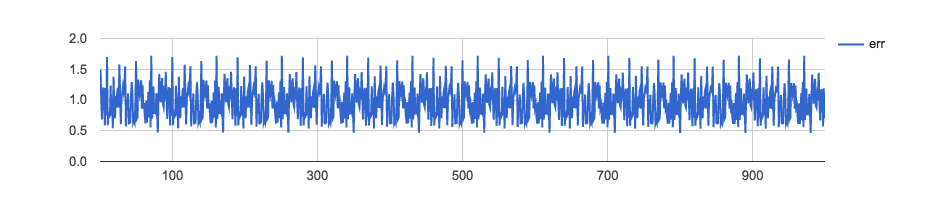

In [335]:
%%chart line --fields batch,err --data graph

## Validate on test set

In [340]:
feed_dict = {x: test_set, y_: numpy.reshape(test_output, [len(test_output),1])}
error, r_y = sess.run([mean_sq_err,y], feed_dict = feed_dict)
print error
print r_y[300]

0.981946
[ 6.85695839]


In [339]:
test_set_raw[300]

['Color',
 'Pierre Coffin',
 '306',
 '98',
 '275',
 '1000',
 'Miranda Cosgrove',
 '7000',
 '368049635',
 'Animation|Comedy|Family|Sci-Fi',
 'Steve Carell',
 'Despicable Me 2\xc2\xa0',
 '286877',
 '11905',
 'Steve Coogan',
 '0',
 'dating|minion|overprotective father|undercover spy|woman agent',
 'http://www.imdb.com/title/tt1690953/?ref_=fn_tt_tt_1',
 '284',
 'English',
 'USA',
 'PG',
 '76000000',
 '2013',
 '2000',
 '7.5',
 '1.85',
 '56000']